# Positive vs. Negative Samples Explained Distribution

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', UserWarning)

In [5]:
import os, sys
from pathlib import Path

curruser = os.environ.get('USER')
sys.path.insert(0, './../src/')
sys.path.insert(0, '/home/{}/notebooks/support_library/'.format(curruser)) 
sys.path.insert(0, '/home/{}/python35-libs/lib/python3.5/site-packages/'.format(curruser))
# sys.path.insert(0, '/home/ufimtsev1-ys_ca-sbrf-ru/notebooks/labdata/lib/')

import gc, os
import itertools
from copy import deepcopy

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

from MulticoreTSNE import MulticoreTSNE as mTSNE

from scipy.stats import ks_2samp

from sklearn.externals import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection

from sklearn import manifold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

from sklearn.externals import joblib

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

from plot import Plot as mplt
# from feature_eng import Featureng as fe

%matplotlib inline

In [6]:
def get_path(folder, file):
    return os.path.join(folder, file)

# 1. t-SNE Distribution Overview
scaling all the data with mean-variance, but for columns where we have outliers (> 3x standard deviation) do a log-transform prior to scaling.

## 1.0. Data Pre-Processing
Current pre-processing procedure:
* Get rows from training set and test set and concatenate them
* Columns with standard deviation of 0 in training set removed
* Columns which are duplicate in training set removed
* Log-transform all columns which have significant outliers (> 3x standard deviation)
* Create datasets with: 
    * Mean-variance scale all columns including 0-values!
    * Mean-variance scale all columns **excluding** 0-values!
    

In [7]:
%%time
csvpath = Path.joinpath(Path(os.getcwd()),'../csv','data4train_sampled_60pct.csv')
df_part = pd.read_csv(csvpath, encoding='cp1251', sep=';', compression='gzip')

CPU times: user 13min 14s, sys: 1min 19s, total: 14min 33s
Wall time: 14min 33s


In [6]:
# Pos/Neg samples' indexes
neg_idx = df_part.loc[(df_part.target==0),:].index.tolist()
pos_idx = df_part.loc[(df_part.target==1),:].index.tolist()

In [8]:
target = df_part.target
df_part.drop(['target'], axis=1, inplace=True)

In [8]:
df_part.shape

(6872301, 514)

### Imputing Missing Values with Strategy

In [9]:
imp=SimpleImputer(missing_values=np.nan, strategy='mean')

In [10]:
df_part_meta=pd.DataFrame(imp.fit_transform(df_part.astype(dtype=np.float32).values), columns=df_part.columns)

In [11]:
df_part_meta.shape

(6872301, 514)

In [12]:
# del df_part

In [13]:
df_part_meta['bank_straxovanie_imush'].value_counts()

0.0    6743771
1.0     128530
Name: bank_straxovanie_imush, dtype: int64

In [14]:
df_part_meta['bank_straxovanie_imush'].mean(axis=0) , \
df_part_meta['bank_straxovanie_imush'].mean() + df_part_meta['bank_straxovanie_imush'].std()*3

(0.018702615052461624, 0.42149700596928596)

### Scaling Process

In [11]:
%%time 
print("df shape before scaling: {}".format(df_part_meta.shape))

# Columns to drop because there is no variation in training set
zero_std_cols = df_part_meta.columns[df_part_meta.std(axis=0) == 0.].values.tolist()
df_part_meta.drop(columns=zero_std_cols, axis=1, inplace=True)
print('Removed {} constant columns'.format(len(zero_std_cols)))

# Removing duplicate columns

# colsToRemove = []
# colsScaned = []
# dupList = {}
# columns = total_df.columns
# for i in range(len(columns)-1):
#     v = total_df[columns[i]].values
#     dupCols = []
#     for j in range(i+1,len(columns)):
#         if np.array_equal(v, total_df[columns[j]].values):
#             colsToRemove.append(columns[j])
#             if columns[j] not in colsScaned:
#                 dupCols.append(columns[j]) 
#                 colsScaned.append(columns[j])
#                 dupList[columns[i]] = dupCols
# colsToRemove = list(set(colsToRemove))
# total_df.drop(colsToRemove, axis=1, inplace=True)
# print('Dropped {} duplicate columns'.format(len(colsToRemove)))

# Go through the columns one at a time (can't do it all at once for this dataset)
for col in tqdm_notebook(df_part_meta.columns):
    
    # Detect outliers in this column
#     data = df_part_meta[col].values.copy()
#     data_mean, data_std = np.mean(data), np.std(data, ddof=0)
#     #print('{} --> mean: {} std: {}'.format(col, data_mean, data_std))
#     cut_off = data_std * 4
#     lower, upper = data_mean - cut_off, data_mean + cut_off
#     outliers = [x for x in data if x < lower or x > upper]
    
    # If there are crazy high values, do a log-transform
#     if len(outliers) > 0:
#         non_zero_idx = (data != 0) & (data != 1) & (data > 0) 
#         if sum(non_zero_idx) > 0 :
#             df_part_meta.loc[non_zero_idx, col] = np.log(data[non_zero_idx])
#             df_part_meta.replace({col: {np.inf: 0, -np.inf: 0}}, inplace=True)

    # Scale non-zero column values
#     nonzero_rows = df_part_meta[col] != 0
#     if any(nonzero_rows):
#         df_part_meta.loc[nonzero_rows, col] = scale(df_part_meta.loc[nonzero_rows, col])
#     else:
#         if df_part_meta[col].std(axis=0) == 0.:
#             print("{} is zero polulated".format(col))
#             zero_std_cols.append(col)
#             df_part_meta.drop(columns=[col], axis=1, inplace=True)

    # Scale all column values
    df_part_meta.loc[:, col] = scale(df_part_meta.loc[:, col])

    gc.collect()
    
print("df shape after scaling: {}".format(df_part_meta.shape))

df shape before scaling: (6872301, 514)
Removed 76 constant columns



df shape after scaling: (6872301, 438)
CPU times: user 1min 37s, sys: 11.5 s, total: 1min 48s
Wall time: 1min 48s


In [ ]:
zero_std_cols

In [17]:
with open('./zero_std_cols', 'w') as f:
    f.writelines("\n".join(zero_std_cols))

## 1.1. Performing PCA
perform PCA prior to the t-SNE to reduce the dimensionality a bit.
include 100 PCA components, which includes about 80% of the variation in the dataset, which I think it allright for saying something about the distributions, but also speeding up t-SNE a bit.

In [18]:
def run_pca(df, neg_idx, pos_idx, n_comp = 70, create_plots=True):
    """Run PCA analysis, return embedding"""
    
    cm = plt.cm.get_cmap('RdYlBu') 
    
    # Create a PCA object, specifying how many components we wish to keep
    pca = PCA(n_components=n_comp)

    # Run PCA on scaled numeric dataframe, and retrieve the projected data
    pca_trafo = pca.fit_transform(df)    

    # The transformed data is in a numpy matrix. This may be inconvenient if we want to further
    # process the data, and have a more visual impression of what each column is etc. We therefore
    # put transformed/projected data into new dataframe, where we specify column names and index
    pca_df = pd.DataFrame(
        pca_trafo,
        index=df.index,
        columns=["PC" + str(i + 1) for i in range(pca_trafo.shape[1])]
    )

    # Only construct plots if requested
    if create_plots:
        
        plt.style.use('seaborn-white')
        
        # Create two plots next to each other
        _, axes = plt.subplots(3, 2, figsize=(20, 15))
        axes = list(itertools.chain.from_iterable(axes))

        # Plot the explained variance# Plot t 
        axes[0].plot(
            pca.explained_variance_ratio_, "--o", linewidth=2,
            label="Explained variance ratio"
        )

        # Plot the cumulative explained variance
        axes[0].plot(
            pca.explained_variance_ratio_.cumsum(), "--o", linewidth=2,
            label="Cumulative explained variance ratio"
        )

        # Show legend
        axes[0].legend(loc="best", frameon=True)

        # Show biplots
        for i in range(1, 6):

            # Components to be plottet
            x, y = "PC"+str(i), "PC"+str(i+1)

            # Plot biplots
            settings = {'kind': 'scatter', 'ax': axes[i], 'alpha': 0.2, 'x': x, 'y': y}
            pca_df.iloc[neg_idx].plot(label='Neg', c='#ff7f0e', **settings)
            pca_df.iloc[pos_idx].plot(label='Pos', c='#1f77b4', **settings)    

        # Show the plot
        plt.show()
    
    return pca, pca_df

## Run the PCA and get the embedded dimension (Scale all column values)

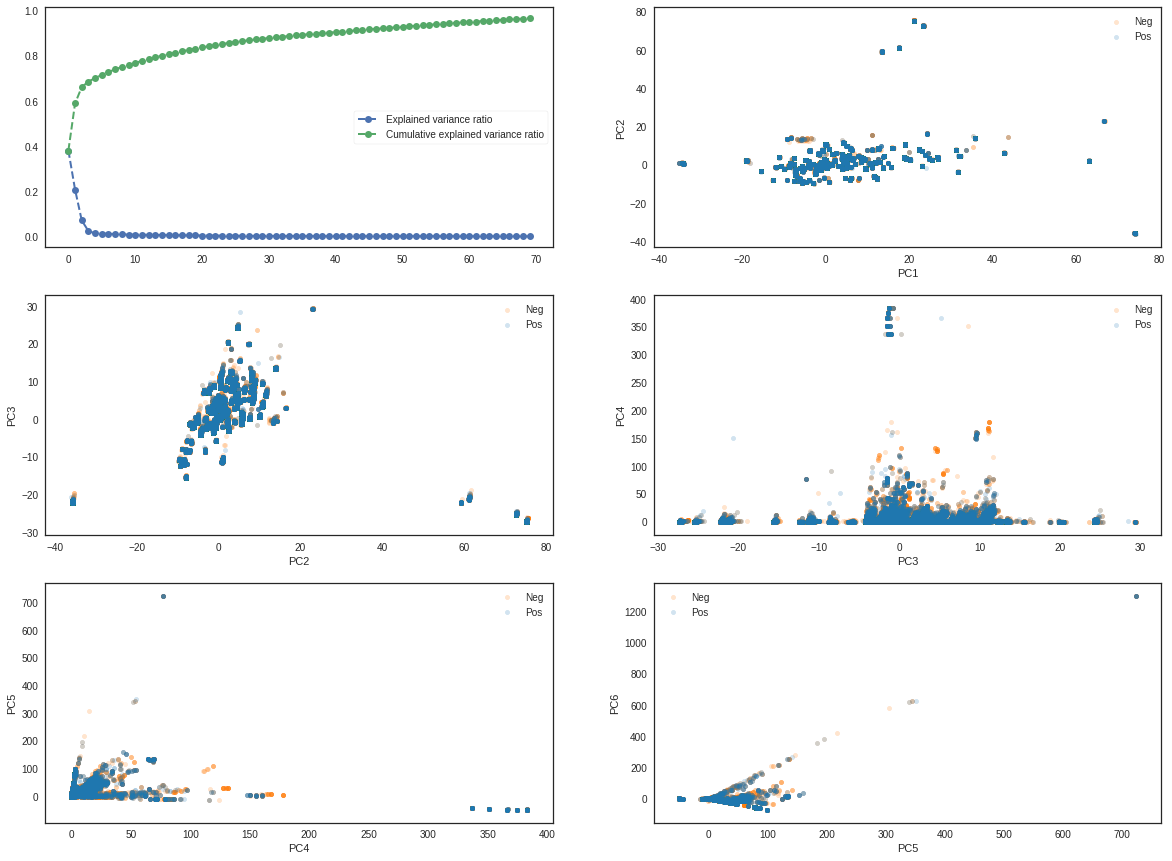

In [19]:
pca, pca_df = run_pca(df_part_meta, neg_idx, pos_idx)

In [20]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70
0,-7.172934,-5.269303,-0.832257,-0.118039,-0.549436,0.539282,-4.323928,-0.064387,0.337944,0.015345,...,-0.128466,-0.025583,-0.125241,-0.121170,-0.014511,-0.533951,0.048649,-0.374873,0.098392,0.556353
1,1.560304,-0.015767,2.456768,-0.178232,-0.207346,0.098898,-0.186196,0.131315,-0.683955,-0.008997,...,2.707649,0.537336,0.999114,0.612021,0.293327,-0.142029,-0.466094,0.093964,-0.236032,0.386115
2,1.540884,-0.024337,2.503430,-0.202471,-0.481373,0.332764,0.155851,0.106404,-0.854719,0.022061,...,-1.862785,0.528527,0.758996,1.860972,-0.106993,0.112448,-0.542686,1.140024,-0.574312,0.080180
3,11.572885,-6.136443,-2.002253,-0.177142,-0.893444,0.713159,-3.186479,-0.172983,0.413906,0.002189,...,-2.496354,0.242992,0.826029,0.500973,0.828324,-0.291385,1.126196,0.362357,0.848053,0.009050
4,1.545294,-0.046534,2.466893,-0.222994,-0.557231,0.324115,0.073626,0.136524,-1.170929,0.031210,...,0.374498,0.016297,0.141070,-0.007503,0.072602,0.027480,-0.060666,-0.042822,-0.246788,-0.103341


In [26]:
joblib.dump(pca,"./../pkl/pca_proj_fitted")

['./../pkl/pca_proj_fitted']

## Performing Gaussian Projection

In [21]:
def run_gauspr(df, neg_idx, pos_idx, n_comp = 70, create_plots=True):
    """Run PCA analysis, return embedding"""
    
    cm = plt.cm.get_cmap('RdYlBu') 
    
    # Create a PCA object, specifying how many components we wish to keep
    gpr = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=42)

    # Run PCA on scaled numeric dataframe, and retrieve the projected data
    gpr_trafo = gpr.fit_transform(df)    

    # The transformed data is in a numpy matrix. This may be inconvenient if we want to further
    # process the data, and have a more visual impression of what each column is etc. We therefore
    # put transformed/projected data into new dataframe, where we specify column names and index
    gpr_df = pd.DataFrame(
        gpr_trafo,
        index=df.index,
        columns=["GPR" + str(i) for i in range(gpr_trafo.shape[1])]
    )

    # Only construct plots if requested
    if create_plots:
        
        plt.style.use('seaborn-white')
        
        # Create two plots next to each other
        _, axes = plt.subplots(3, 2, figsize=(20, 15))
        axes = list(itertools.chain.from_iterable(axes))

        # Show biplots
        for i in range(0, 6):

            # Components to be plottet
            x, y = "GPR"+str(i), "GPR"+str(i+1)

            # Plot biplots
            settings = {'kind': 'scatter', 'ax': axes[i], 'alpha': 0.2, 'x': x, 'y': y}
            gpr_df.iloc[neg_idx].plot(label='Neg', c='#ff7f0e', **settings)
            gpr_df.iloc[pos_idx].plot(label='Pos', c='#1f77b4', **settings)    

        # Show the plot
        plt.show()
    
    return gpr, gpr_df

## Run the GPR and get the embedded dimension (Scale all column values)

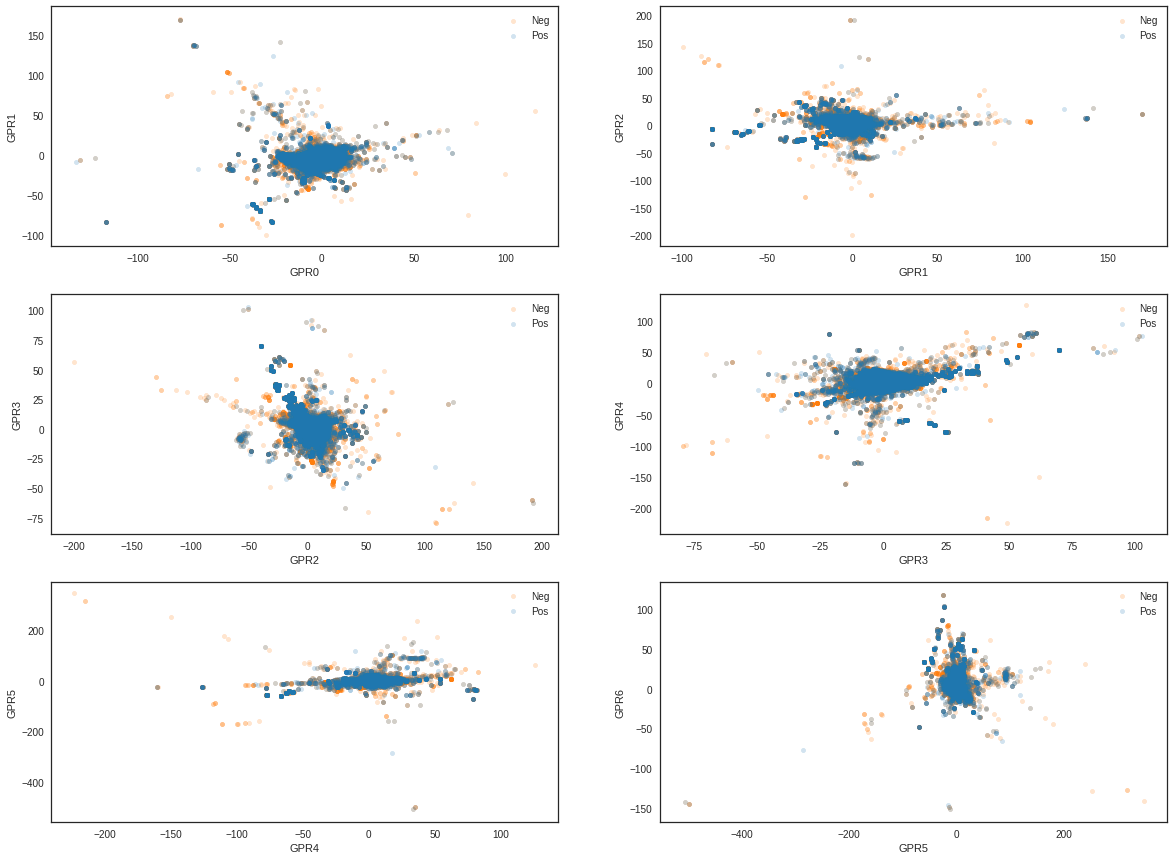

In [22]:
gpr, gpr_df = run_gauspr(df_part_meta, neg_idx, pos_idx, n_comp=70)

In [23]:
gpr_df.head()

,GPR0,GPR1,GPR2,GPR3,GPR4,GPR5,GPR6,GPR7,GPR8,GPR9,...,GPR60,GPR61,GPR62,GPR63,GPR64,GPR65,GPR66,GPR67,GPR68,GPR69
0,1.402725,1.186889,-2.699291,2.092274,-3.241320,-1.279777,-0.190645,4.595253,-0.796166,-2.596661,...,1.570065,-0.722007,-0.001974,-2.283783,1.487609,-1.404909,1.775553,-0.401012,-1.316357,-0.951602
1,1.626152,-0.098548,1.631473,-0.843087,1.996159,-1.824735,0.173529,0.647634,-0.341882,0.829198,...,0.060717,0.235644,-0.587353,1.033626,-0.368495,0.614435,2.235622,-1.351140,0.392698,0.330459
2,-0.875088,-1.169076,1.079368,-0.010181,-0.349269,-1.521587,1.820423,-0.315059,1.218476,-0.010513,...,-2.494919,-1.312910,-0.902907,-0.901747,-1.298232,2.862035,1.468141,0.454440,0.337795,-0.029481
3,-4.342627,-0.421118,-0.322984,1.254835,-1.436819,0.315760,3.023103,3.354246,0.017544,-5.994703,...,-0.578048,-1.305786,-3.420208,-1.025587,3.368697,-1.885720,1.109000,-0.972593,-3.988421,-1.032837
4,0.291552,0.149230,-0.348024,-0.291293,0.960545,-0.823363,0.158286,0.511203,-0.046723,0.012173,...,-0.602233,0.609218,0.789858,-0.249803,0.287759,-0.208385,0.295924,0.564106,0.357087,0.527251


In [25]:
joblib.dump(gpr,"./../pkl/gaussian_rand_proj_fitted")

['./../pkl/gaussian_rand_proj_fitted']

## 1.2. Running t-SNE
run the t-SNE and subsequently plot both pos and neg samples in the embedded 2D space.

In [113]:
def run_tsne(data, pos_idx, neg_idx, initstr='pca', ax=None, title='t-SNE'):
    """Run t-SNE and return embedding"""
    cm = plt.cm.get_cmap('RdYlBu') 
    # Run t-SNE
    if initstr=='pca':
        tsne = TSNE(n_components=2, init=initstr, perplexity=100, n_iter=500)    
    else:   
        tsne = mTSNE(n_components=2, init=initstr, perplexity=600, n_iter=1000, n_jobs=40)
    Y = tsne.fit_transform(data)

    # Create plot
    for name, idx in zip(["Pos", "Neg"], [pos_idx, neg_idx]):
        ax.scatter(Y[idx, 0], Y[idx, 1], label=name, alpha=0.2, cmap=cm)
        ax.set_title(title)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
    ax.legend()        
    return tsne, Y 

In [ ]:
# Run t-SNE on PCA embedding
_, axes = plt.subplots(1, 1, figsize=(20, 8))

# tsne_df = test_tsne(
#     pca_df, axes[0],
#     title='t-SNE: Scaling on non-zeros'
# )
tsne, tsne_df_unique = run_tsne(
                                pca_df,
                                pos_idx, 
                                neg_idx,
                                initstr='pca',
                                ax=axes,
                                title='t-SNE: Scaling on all entries'
                               )

plt.axis('tight')
plt.show() 

 ### 1.2.1. t-SNE colored by row-index or zero-count
data is time separated, so it'd be interesting to look a bit more into why the t-SNE looks as it does. The two most obvious measures to investigate, that I could come up with off the top of my head, were the index of the rows (as a measure of 'time', assuming data is not shuffled), and the number of zeros for the given rows.

In [ ]:
gc.collect()
# Get our color map
cm = plt.cm.get_cmap('RdYlBu')

# Create plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sc = axes[0].scatter(tsne_df_unique[:, 0], tsne_df_unique[:, 1], alpha=0.2, c=range(len(tsne_df_unique)), cmap=cm)
cbar = fig.colorbar(sc, ax=axes[0])
cbar.set_label('Entry index')
axes[0].set_title("t-SNE colored by index")
axes[0].xaxis.set_major_formatter(NullFormatter())
axes[0].yaxis.set_major_formatter(NullFormatter())

zero_count = (df_part_meta == 0.).sum(axis=1).values
sc = axes[1].scatter(tsne_df_unique[:, 0], tsne_df_unique[:, 1], alpha=0.2, c=zero_count, cmap=cm)
cbar = fig.colorbar(sc, ax=axes[1])
cbar.set_label('#sparse entries')
axes[1].set_title("t-SNE colored by number of zeros")
axes[1].xaxis.set_major_formatter(NullFormatter())
axes[1].yaxis.set_major_formatter(NullFormatter())
 

Looks pretty interesting - seems like the higher-index rows are located more at the center of the plot. Also, we see a small cluster of rows with few zero-entries, as well as a few more clusters in the right-hand figure.

### 1.2.2. t-SNE with different perplexities
t-SNE can give some pretty tricky to intepret results depending on the perplexity parameter used. So just to be sure in the following I check for a few different values of the perplexity parameter.

In [ ]:
_, axes = plt.subplots(1, 4, figsize=(20, 6))
for i, perplexity in enumerate([300, 500, 1000, 1500]):
    
    # Create projection
    Y = TSNE(init='pca', perplexity=perplexity).fit_transform(pca_df)
    
    # Plot t-SNE
    for name, idx in zip(["Pos", "Neg"], [pos_idx, neg_idx]):
        axes[i].scatter(Y[idx, 0], Y[idx, 1], label=name, alpha=0.2)
    axes[i].set_title("Perplexity=%d" % perplexity)
    axes[i].xaxis.set_major_formatter(NullFormatter())
    axes[i].yaxis.set_major_formatter(NullFormatter())
    axes[i].legend() 

plt.show()

Clearly the different train target values are located at different locations in the t-SNE plot.

## Generalizing E–M: Gaussian Mixture Models

In [13]:
from sklearn.mixture import GaussianMixture as GMM

### Split samples onto batches

In [14]:
batches = np.array_split(df_part_meta.index, 7)

### Incremental Fit of Gaussian Model using batch generator 

In [15]:
# Iterator for FastText train
class BatchIter(object):
    def __init__(self, df, batches):
        self.df = df
    def __iter__(self):
            for batch in batches:
                yield self.df.iloc[batch,:]

In [46]:
gmm = GMM(n_components=2, warm_start=True, covariance_type='full', init_params ='kmeans')

In [47]:
%%time
for data in tqdm_notebook(BatchIter(df_part_meta, batches), total=len(batches)):
    gmm.fit(data.astype(dtype=np.float32))



CPU times: user 2h 23min 47s, sys: 1h 18min 50s, total: 3h 42min 37s
Wall time: 27min 15s


In [97]:
joblib.dump(gmm,"./../pkl/gauss_mixture_model_kmeans_fitted")

['./../pkl/gauss_mixture_model_kmeans_fitted']

### Make a prediction with mini-batches using fitted GMM model

In [16]:
def run_gmm(gmm, gpr_df, df, batches, neg_idx, pos_idx):
    """Run PCA analysis, return embedding"""
    
    cm = plt.cm.get_cmap('RdYlBu') 
    
    all_labels = np.array([])
    for data in tqdm_notebook(BatchIter(df, batches), total=len(batches)):
        labels     = gmm.predict(data.astype(dtype=np.float32))    
        all_labels = np.append(all_labels,labels)
        
    plt.style.use('seaborn-white')

    # Create two plots next to each other
    _, axes = plt.subplots(3, 2, figsize=(20, 15))
    axes = list(itertools.chain.from_iterable(axes))

    # Show biplots
    for i in range(0, 6):

        # Components to be plottet
        x, y = "GPR"+str(i), "GPR"+str(i+1)

        # Plot biplots
        settings = {'kind': 'scatter', 'ax': axes[i], 'alpha': 0.2, 'x': x, 'y': y, 'cmap': cm}
        gpr_df.iloc[neg_idx].plot(label='Neg', c=all_labels[neg_idx], **settings)
        gpr_df.iloc[pos_idx].plot(label='Pos', c=all_labels[pos_idx], **settings)       
    
    return all_labels

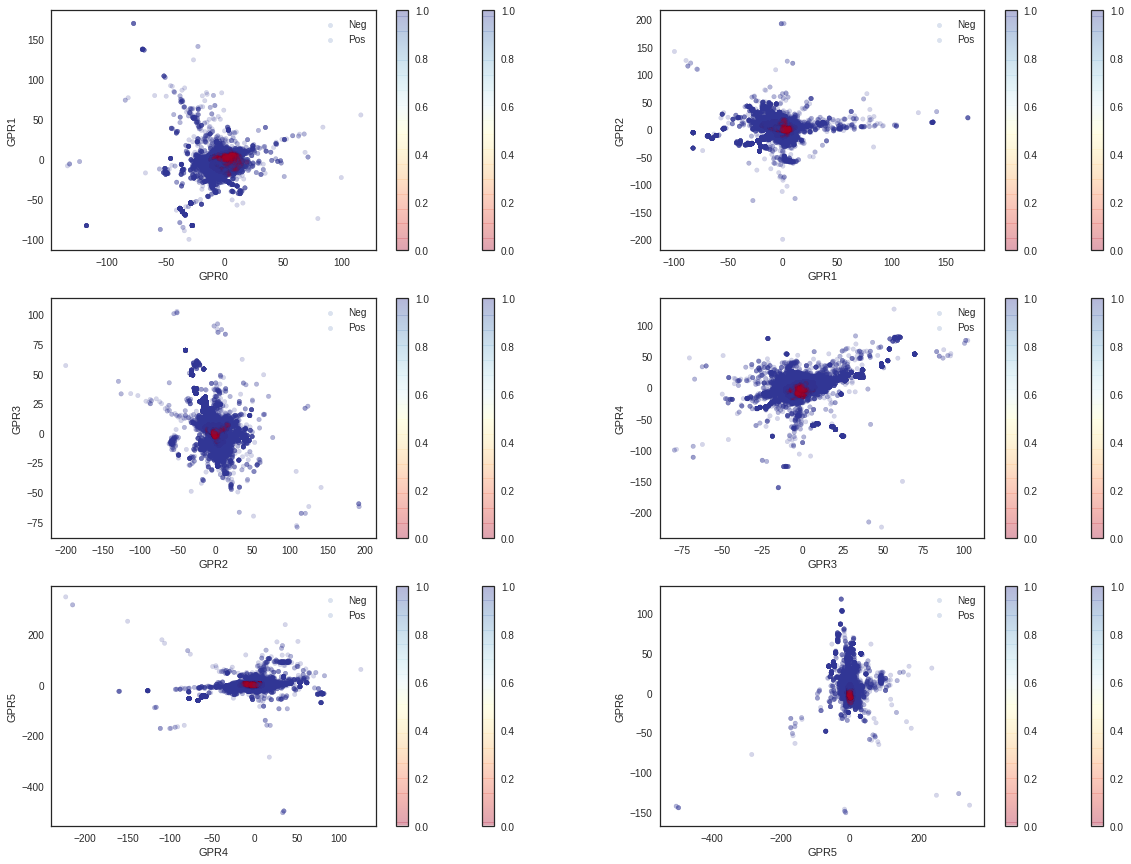

In [93]:
labels = run_gmm(gmm, gpr_df, df_part_meta, batches, neg_idx, pos_idx)

### Obtain cluster' probabilities with mini-batches using fitted GMM model

In [17]:
gmm = joblib.load("./../pkl/gauss_mixture_model_kmeans_fitted")

In [18]:
gmm_probs = []
for data in tqdm_notebook(BatchIter(df_part_meta, batches), total=len(batches)):
    probs     = gmm.predict_proba(data.astype(dtype=np.float32))    
    gmm_probs.extend(probs)

In [19]:
gmm_proba_df = pd.DataFrame(gmm_probs, columns = ["GMM0","GMM1"])

In [171]:
gmm_proba_df[(gmm_proba_df['GMM0']>0.5)&(gmm_proba_df['GMM0']<0.8)].head()

,GMM0,GMM1
660766,0.689802,0.310198
1208664,0.523862,0.476138
1224553,0.582529,0.417471
1338877,0.569791,0.430209
1628711,0.522903,0.477097


In [20]:
del gmm_probs

# Retrain Fine-Tuned XGB on Stacked DataSet (StatsFiltering+Scaling+GMM_Probs)

In [32]:
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, \
                            classification_report, precision_score, \
                            recall_score, roc_curve, precision_recall_curve, \
                            average_precision_score, make_scorer, confusion_matrix, get_scorer

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from time import time

In [22]:
def get_metrics(y_pred, y, average='binary'):
    print(classification_report(y, y_pred, digits=5, ))
    recall = recall_score(y, y_pred, average=average)
    precision=precision_score(y, y_pred,average=average)
    f1=f1_score(y, y_pred,average=average)
    
    return recall, precision, f1

In [23]:
def feature_impotance(model, X_train, count_top_features = 20):
    imp=model.feature_importances_
    names=X_train.columns
    imp, names=map(list, zip(*sorted(zip(imp, names))[::-1][:count_top_features]))
    
    fig, ax = plt.subplots(figsize=(9,12))
    #ax = plt.axes()
    sns.barplot(x=imp, y=names, palette=sns.color_palette('YlGn', 2), ax=ax)
    ax.set_title('Top ' + str(count_top_features) + ' important features')
    plt.show()

In [41]:
df_part_meta.shape

(6872301, 438)

In [24]:
ext_df = pd.concat([df_part_meta, gmm_proba_df], axis=1)
ext_df.shape

(6872301, 440)

In [25]:
X_train, X_test, y_train, y_test = \
train_test_split(ext_df, target, 
                 random_state=42, shuffle=True, test_size=0.2)

### Load Fine-Tuned Instance of XGB

In [55]:
cls_pipe = joblib.load('./../pkl/xgb_cls_tuned_pipe_wFT_200606.pkl')

In [56]:
xgb = cls_pipe['clf']

### Copy Best FT params and train again XGB model on new stacked data

In [57]:
xgb_params = xgb.get_params()
# xgb_params = dict(xgb_params,**{'update':'refresh','process_type':'update','refresh_leaf':True,'xgb_model':xgb})

In [36]:
# xgb_params['feature_fraction'] = 1
# xgb_params['colsample_bytree'] = 1
# xgb_params['bagging_fraction'] = 1

In [58]:
classifier = XGBClassifier(**xgb_params)
classifier

XGBClassifier(bagging_fraction=0.5, bagging_freq=0, base_score=0.5,
              booster='gbtree', colsample_bylevel=1, colsample_bytree=0.7,
              feature_fraction=0.7, gamma=0, lambda_l1=0, lambda_l2=0.01,
              learning_rate=0.08, max_bin=180, max_delta_step=0, max_depth=10,
              min_child_samples=100, min_child_weight=1e-05,
              min_data_in_leaf=100, missing=nan, n_estimators=500, n_jobs=40,
              nthread=None, num_leaves=128, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2.041, seed=None, silent=True, subsample=1, ...)

In [39]:
classifier.fit(X_train.astype(dtype=np.float32), y_train)

[19:48:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


XGBClassifier(bagging_fraction=1, bagging_freq=0, base_score=0.5,
              booster='gbtree', colsample_bylevel=1, colsample_bytree=1,
              feature_fraction=1, gamma=0, lambda_l1=0, lambda_l2=0.01,
              learning_rate=0.08, max_bin=180, max_delta_step=0, max_depth=10,
              min_child_samples=100, min_child_weight=1e-05,
              min_data_in_leaf=100, missing=nan, n_estimators=500, n_jobs=40,
              nthread=None, num_leaves=128, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2.041, seed=None, silent=True, subsample=1, ...)

In [40]:
y_pred = classifier.predict(X_test.astype(dtype=np.float32))

recall_ts, precision_ts, f1_ts =  get_metrics(y_pred.astype(int), y_test.astype(int))
                                                  
print('Hold Out: ')
print('Precision: %7.5f, Recall: %7.5f, F_1: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

              precision    recall  f1-score   support

           0    0.75393   0.72283   0.73805    922443
           1    0.47829   0.51855   0.49761    452018

    accuracy                        0.65565   1374461
   macro avg    0.61611   0.62069   0.61783   1374461
weighted avg    0.66328   0.65565   0.65898   1374461

Hold Out: 
Precision: 0.47829, Recall: 0.51855, F_1: 0.49761


In [43]:
del ext_df

### Add GausianRandomProj Principal Coponents

In [44]:
gproj = joblib.load("./../pkl/gaussian_rand_proj_fitted")

In [48]:
gpr_nd = gproj.transform(df_part_meta)

In [49]:
gpr_df = pd.DataFrame(
    gpr_nd,
    index=df_part_meta.index,
    columns=["GPR" + str(i) for i in range(gpr_nd.shape[1])]
)

In [50]:
del gpr_nd

In [51]:
ext_df = pd.concat([df_part_meta, gpr_df], axis=1)
ext_df.shape

(6872301, 508)

In [52]:
ext_df.head()

,OPF_IP,OPF_OOO,OPF_Other,acquiring_mobile,acquiring_torg,acreditiv,all_prod_deals_completed,all_prod_deals_created,bank_straxovanie_imush,bank_straxovanie_lich,...,GPR60,GPR61,GPR62,GPR63,GPR64,GPR65,GPR66,GPR67,GPR68,GPR69
0,2.472724,-0.328046,-0.0865,-0.094935,-0.642232,-0.028687,-0.211345,-0.198013,-0.138055,-0.178121,...,1.570065,-0.722007,-0.001974,-2.283783,1.487609,-1.404909,1.775553,-0.401012,-1.316357,-0.951602
1,-0.404411,-0.328046,-0.0865,10.533563,1.557070,-0.028687,-0.211345,-0.198013,-0.138055,-0.178121,...,0.060717,0.235644,-0.587353,1.033626,-0.368495,0.614435,2.235622,-1.351140,0.392698,0.330459
2,-0.404411,-0.328046,-0.0865,-0.094935,-0.642232,-0.028687,-0.211345,-0.198013,-0.138055,-0.178121,...,-2.494919,-1.312910,-0.902907,-0.901747,-1.298232,2.862035,1.468141,0.454440,0.337795,-0.029481
3,-0.404411,3.048358,-0.0865,-0.094935,1.557070,-0.028687,-0.211345,-0.198013,-0.138055,-0.178121,...,-0.578048,-1.305786,-3.420208,-1.025587,3.368697,-1.885720,1.109000,-0.972593,-3.988421,-1.032837
4,-0.404411,-0.328046,-0.0865,-0.094935,-0.642232,-0.028687,-0.211345,-0.198013,-0.138055,-0.178121,...,-0.602233,0.609218,0.789858,-0.249803,0.287759,-0.208385,0.295924,0.564106,0.357087,0.527251


In [53]:
X_train, X_test, y_train, y_test = \
train_test_split(ext_df, target, 
                 random_state=42, shuffle=True, test_size=0.2)

In [59]:
classifier.fit(X_train.astype(dtype=np.float32), y_train)

[23:33:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


XGBClassifier(bagging_fraction=0.5, bagging_freq=0, base_score=0.5,
              booster='gbtree', colsample_bylevel=1, colsample_bytree=0.7,
              feature_fraction=0.7, gamma=0, lambda_l1=0, lambda_l2=0.01,
              learning_rate=0.08, max_bin=180, max_delta_step=0, max_depth=10,
              min_child_samples=100, min_child_weight=1e-05,
              min_data_in_leaf=100, missing=nan, n_estimators=500, n_jobs=40,
              nthread=None, num_leaves=128, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2.041, seed=None, silent=True, subsample=1, ...)

In [60]:
y_pred = classifier.predict(X_test.astype(dtype=np.float32))

recall_ts, precision_ts, f1_ts =  get_metrics(y_pred.astype(int), y_test.astype(int))
                                                  
print('Hold Out: ')
print('Precision: %7.5f, Recall: %7.5f, F_1: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

              precision    recall  f1-score   support

           0    0.75056   0.70606   0.72763    922443
           1    0.46490   0.52115   0.49142    452018

    accuracy                        0.64525   1374461
   macro avg    0.60773   0.61360   0.60953   1374461
weighted avg    0.65662   0.64525   0.64995   1374461

Hold Out: 
Precision: 0.46490, Recall: 0.52115, F_1: 0.49142


In [54]:
del ext_df